<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[17:10:30] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


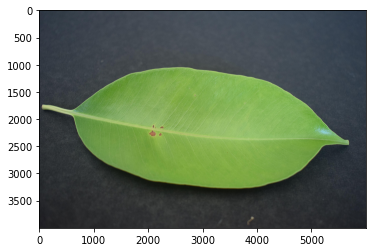

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

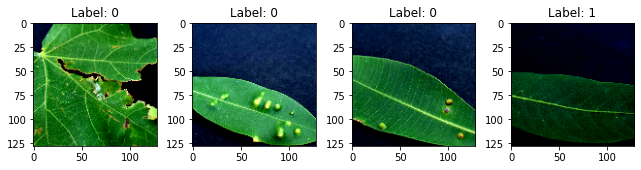

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
device = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, device=device)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), device=device))
model.hybridize()

[17:10:36] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[17:10:38] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.to_device(device))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.to_device(device))
            loss = loss_fn(outputs, label.to_device(device))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2491982546742697 samples/sec                   batch loss = 0.6634359955787659 | accuracy = 0.35


Epoch[1] Batch[10] Speed: 1.256934213822757 samples/sec                   batch loss = 0.5534056425094604 | accuracy = 0.45


Epoch[1] Batch[15] Speed: 1.2543838570046235 samples/sec                   batch loss = 1.1576251983642578 | accuracy = 0.5666666666666667


Epoch[1] Batch[20] Speed: 1.2542398172542961 samples/sec                   batch loss = 0.7568064332008362 | accuracy = 0.5375


Epoch[1] Batch[25] Speed: 1.2537336899768805 samples/sec                   batch loss = 0.3560370206832886 | accuracy = 0.57


Epoch[1] Batch[30] Speed: 1.2551849310917806 samples/sec                   batch loss = 0.6871290802955627 | accuracy = 0.575


Epoch[1] Batch[35] Speed: 1.2395713179139947 samples/sec                   batch loss = 0.6916080713272095 | accuracy = 0.5571428571428572


Epoch[1] Batch[40] Speed: 1.257236943960642 samples/sec                   batch loss = 0.2325311303138733 | accuracy = 0.56875


Epoch[1] Batch[45] Speed: 1.2684302385581345 samples/sec                   batch loss = 0.5924192667007446 | accuracy = 0.5888888888888889


Epoch[1] Batch[50] Speed: 1.2663509221024944 samples/sec                   batch loss = 0.43283918499946594 | accuracy = 0.58


Epoch[1] Batch[55] Speed: 1.2579129141388956 samples/sec                   batch loss = 1.6941848993301392 | accuracy = 0.5772727272727273


Epoch[1] Batch[60] Speed: 1.2636852404488559 samples/sec                   batch loss = 1.1401251554489136 | accuracy = 0.5916666666666667


Epoch[1] Batch[65] Speed: 1.2542408486713643 samples/sec                   batch loss = 0.23469600081443787 | accuracy = 0.5923076923076923


Epoch[1] Batch[70] Speed: 1.2559317438294548 samples/sec                   batch loss = 0.9762496948242188 | accuracy = 0.5892857142857143


Epoch[1] Batch[75] Speed: 1.2524448188965116 samples/sec                   batch loss = 0.15160679817199707 | accuracy = 0.6


Epoch[1] Batch[80] Speed: 1.2558085919944861 samples/sec                   batch loss = 0.38649478554725647 | accuracy = 0.603125


Epoch[1] Batch[85] Speed: 1.2511510374233048 samples/sec                   batch loss = 0.41509386897087097 | accuracy = 0.6


Epoch[1] Batch[90] Speed: 1.255588389044034 samples/sec                   batch loss = 0.3914089798927307 | accuracy = 0.6111111111111112


Epoch[1] Batch[95] Speed: 1.2606172594517089 samples/sec                   batch loss = 0.6910592317581177 | accuracy = 0.6157894736842106


Epoch[1] Batch[100] Speed: 1.258770350934083 samples/sec                   batch loss = 0.9863742589950562 | accuracy = 0.61


Epoch[1] Batch[105] Speed: 1.2599987503064152 samples/sec                   batch loss = 0.5976434946060181 | accuracy = 0.6071428571428571


Epoch[1] Batch[110] Speed: 1.2507361594969626 samples/sec                   batch loss = 0.29850971698760986 | accuracy = 0.6090909090909091


Epoch[1] Batch[115] Speed: 1.2535928905453473 samples/sec                   batch loss = 0.5324912667274475 | accuracy = 0.6043478260869565


Epoch[1] Batch[120] Speed: 1.2561263917764125 samples/sec                   batch loss = 0.7235909700393677 | accuracy = 0.6


Epoch[1] Batch[125] Speed: 1.2536696096674416 samples/sec                   batch loss = 0.42747488617897034 | accuracy = 0.604


Epoch[1] Batch[130] Speed: 1.25513187617618 samples/sec                   batch loss = 0.6794514060020447 | accuracy = 0.6019230769230769


Epoch[1] Batch[135] Speed: 1.248466486618542 samples/sec                   batch loss = 0.994330883026123 | accuracy = 0.5944444444444444


Epoch[1] Batch[140] Speed: 1.2509652970275473 samples/sec                   batch loss = 0.38737836480140686 | accuracy = 0.5946428571428571


Epoch[1] Batch[145] Speed: 1.2664392484979674 samples/sec                   batch loss = 0.25421130657196045 | accuracy = 0.603448275862069


Epoch[1] Batch[150] Speed: 1.2671804710040937 samples/sec                   batch loss = 0.5550870895385742 | accuracy = 0.6033333333333334


Epoch[1] Batch[155] Speed: 1.2500802665333226 samples/sec                   batch loss = 0.725219190120697 | accuracy = 0.6016129032258064


Epoch[1] Batch[160] Speed: 1.2589257300410839 samples/sec                   batch loss = 0.3820864260196686 | accuracy = 0.5984375


Epoch[1] Batch[165] Speed: 1.2573169365387995 samples/sec                   batch loss = 0.7726367712020874 | accuracy = 0.5984848484848485


Epoch[1] Batch[170] Speed: 1.264343295268627 samples/sec                   batch loss = 0.43409091234207153 | accuracy = 0.6029411764705882


Epoch[1] Batch[175] Speed: 1.2602118889399334 samples/sec                   batch loss = 0.6373919248580933 | accuracy = 0.6028571428571429


Epoch[1] Batch[180] Speed: 1.2612858710436188 samples/sec                   batch loss = 0.8246176242828369 | accuracy = 0.6


Epoch[1] Batch[185] Speed: 1.2569457966429183 samples/sec                   batch loss = 0.9679978489875793 | accuracy = 0.595945945945946


Epoch[1] Batch[190] Speed: 1.2584344098358393 samples/sec                   batch loss = 0.6608434915542603 | accuracy = 0.5960526315789474


Epoch[1] Batch[195] Speed: 1.2563043546631003 samples/sec                   batch loss = 0.6873918771743774 | accuracy = 0.5987179487179487


Epoch[1] Batch[200] Speed: 1.2563588258988556 samples/sec                   batch loss = 0.7004538178443909 | accuracy = 0.60375


Epoch[1] Batch[205] Speed: 1.261181101906436 samples/sec                   batch loss = 0.44225069880485535 | accuracy = 0.6024390243902439


Epoch[1] Batch[210] Speed: 1.2555058915672055 samples/sec                   batch loss = 0.7444629669189453 | accuracy = 0.6023809523809524


Epoch[1] Batch[215] Speed: 1.2525268210640987 samples/sec                   batch loss = 0.631809651851654 | accuracy = 0.6034883720930233


Epoch[1] Batch[220] Speed: 1.2563178073960874 samples/sec                   batch loss = 0.49973317980766296 | accuracy = 0.6022727272727273


Epoch[1] Batch[225] Speed: 1.259322994812725 samples/sec                   batch loss = 0.8250045776367188 | accuracy = 0.6033333333333334


Epoch[1] Batch[230] Speed: 1.2550070974274519 samples/sec                   batch loss = 0.50794917345047 | accuracy = 0.6076086956521739


Epoch[1] Batch[235] Speed: 1.2501818019778357 samples/sec                   batch loss = 0.6170732975006104 | accuracy = 0.6085106382978723


Epoch[1] Batch[240] Speed: 1.2420000407159342 samples/sec                   batch loss = 0.4309544861316681 | accuracy = 0.609375


Epoch[1] Batch[245] Speed: 1.2663857158783944 samples/sec                   batch loss = 0.42394381761550903 | accuracy = 0.610204081632653


Epoch[1] Batch[250] Speed: 1.2749551183883596 samples/sec                   batch loss = 0.5338220596313477 | accuracy = 0.612


Epoch[1] Batch[255] Speed: 1.2588482718314922 samples/sec                   batch loss = 0.4784458875656128 | accuracy = 0.6147058823529412


Epoch[1] Batch[260] Speed: 1.2592850907578808 samples/sec                   batch loss = 0.7402962446212769 | accuracy = 0.6153846153846154


Epoch[1] Batch[265] Speed: 1.26677383428785 samples/sec                   batch loss = 0.492742121219635 | accuracy = 0.619811320754717


Epoch[1] Batch[270] Speed: 1.256918864560701 samples/sec                   batch loss = 0.28762874007225037 | accuracy = 0.6212962962962963


Epoch[1] Batch[275] Speed: 1.2565314904741653 samples/sec                   batch loss = 0.600890040397644 | accuracy = 0.6263636363636363


Epoch[1] Batch[280] Speed: 1.260304662729176 samples/sec                   batch loss = 0.5563697218894958 | accuracy = 0.6276785714285714


Epoch[1] Batch[285] Speed: 1.2602856335221897 samples/sec                   batch loss = 0.4638262093067169 | accuracy = 0.6298245614035087


Epoch[1] Batch[290] Speed: 1.2533117610405917 samples/sec                   batch loss = 1.0929625034332275 | accuracy = 0.6310344827586207


Epoch[1] Batch[295] Speed: 1.2489942178647573 samples/sec                   batch loss = 2.2032570838928223 | accuracy = 0.6305084745762712


Epoch[1] Batch[300] Speed: 1.2554572250195328 samples/sec                   batch loss = 0.674375057220459 | accuracy = 0.6308333333333334


Epoch[1] Batch[305] Speed: 1.2551635207807426 samples/sec                   batch loss = 0.3839617371559143 | accuracy = 0.6336065573770492


Epoch[1] Batch[310] Speed: 1.2603028639238236 samples/sec                   batch loss = 0.9873164892196655 | accuracy = 0.6330645161290323


Epoch[1] Batch[315] Speed: 1.250342429332565 samples/sec                   batch loss = 0.6239151358604431 | accuracy = 0.6349206349206349


Epoch[1] Batch[320] Speed: 1.2529522451880293 samples/sec                   batch loss = 0.7628123760223389 | accuracy = 0.63671875


Epoch[1] Batch[325] Speed: 1.2524425749744488 samples/sec                   batch loss = 0.5790973901748657 | accuracy = 0.6376923076923077


Epoch[1] Batch[330] Speed: 1.253757487549273 samples/sec                   batch loss = 0.818740963935852 | accuracy = 0.6356060606060606


Epoch[1] Batch[335] Speed: 1.2585315480623913 samples/sec                   batch loss = 0.5887256264686584 | accuracy = 0.6350746268656716


Epoch[1] Batch[340] Speed: 1.242441712742021 samples/sec                   batch loss = 0.7940174341201782 | accuracy = 0.6367647058823529


Epoch[1] Batch[345] Speed: 1.2648442950504415 samples/sec                   batch loss = 1.4065327644348145 | accuracy = 0.6376811594202898


Epoch[1] Batch[350] Speed: 1.2681809506207975 samples/sec                   batch loss = 0.7286194562911987 | accuracy = 0.64


Epoch[1] Batch[355] Speed: 1.2617035086818178 samples/sec                   batch loss = 0.7301616072654724 | accuracy = 0.6415492957746479


Epoch[1] Batch[360] Speed: 1.2551035194588664 samples/sec                   batch loss = 0.34172186255455017 | accuracy = 0.6423611111111112


Epoch[1] Batch[365] Speed: 1.25479796793706 samples/sec                   batch loss = 0.8416586518287659 | accuracy = 0.6445205479452055


Epoch[1] Batch[370] Speed: 1.258667321262276 samples/sec                   batch loss = 0.43792983889579773 | accuracy = 0.643918918918919


Epoch[1] Batch[375] Speed: 1.2520758018141096 samples/sec                   batch loss = 0.36231720447540283 | accuracy = 0.6453333333333333


Epoch[1] Batch[380] Speed: 1.249706125075224 samples/sec                   batch loss = 0.20728912949562073 | accuracy = 0.6467105263157895


Epoch[1] Batch[385] Speed: 1.2524360302476913 samples/sec                   batch loss = 0.4049912691116333 | accuracy = 0.6474025974025974


Epoch[1] Batch[390] Speed: 1.2506677236239572 samples/sec                   batch loss = 0.531182050704956 | accuracy = 0.6467948717948718


Epoch[1] Batch[395] Speed: 1.249639011891417 samples/sec                   batch loss = 0.11866272240877151 | accuracy = 0.6487341772151899


Epoch[1] Batch[400] Speed: 1.2547833277290008 samples/sec                   batch loss = 0.4008793532848358 | accuracy = 0.64625


Epoch[1] Batch[405] Speed: 1.2506525270280444 samples/sec                   batch loss = 0.3120279312133789 | accuracy = 0.6487654320987655


Epoch[1] Batch[410] Speed: 1.2490442444235772 samples/sec                   batch loss = 0.917417585849762 | accuracy = 0.650609756097561


Epoch[1] Batch[415] Speed: 1.2477932966316114 samples/sec                   batch loss = 0.4846869707107544 | accuracy = 0.6512048192771084


Epoch[1] Batch[420] Speed: 1.248957769810153 samples/sec                   batch loss = 0.21688181161880493 | accuracy = 0.6517857142857143


Epoch[1] Batch[425] Speed: 1.2493955660395766 samples/sec                   batch loss = 0.6613175868988037 | accuracy = 0.6511764705882352


Epoch[1] Batch[430] Speed: 1.2480892250676054 samples/sec                   batch loss = 0.7510669231414795 | accuracy = 0.6523255813953488


Epoch[1] Batch[435] Speed: 1.2497410342272823 samples/sec                   batch loss = 0.32071027159690857 | accuracy = 0.6540229885057471


Epoch[1] Batch[440] Speed: 1.2399636995452243 samples/sec                   batch loss = 0.1782994568347931 | accuracy = 0.6556818181818181


Epoch[1] Batch[445] Speed: 1.2402454733323305 samples/sec                   batch loss = 1.0468274354934692 | accuracy = 0.6567415730337078


Epoch[1] Batch[450] Speed: 1.2697085141877145 samples/sec                   batch loss = 0.5495808720588684 | accuracy = 0.6572222222222223


Epoch[1] Batch[455] Speed: 1.2659300115793717 samples/sec                   batch loss = 0.2698465883731842 | accuracy = 0.6587912087912088


Epoch[1] Batch[460] Speed: 1.2485022556395453 samples/sec                   batch loss = 1.4312355518341064 | accuracy = 0.6592391304347827


Epoch[1] Batch[465] Speed: 1.2538741461983334 samples/sec                   batch loss = 0.5822544097900391 | accuracy = 0.6591397849462366


Epoch[1] Batch[470] Speed: 1.2594694336551844 samples/sec                   batch loss = 0.545508086681366 | accuracy = 0.6595744680851063


Epoch[1] Batch[475] Speed: 1.259904413108154 samples/sec                   batch loss = 0.4588339626789093 | accuracy = 0.6594736842105263


Epoch[1] Batch[480] Speed: 1.2569786628802204 samples/sec                   batch loss = 0.45106738805770874 | accuracy = 0.6604166666666667


Epoch[1] Batch[485] Speed: 1.2501004791555488 samples/sec                   batch loss = 0.3747105002403259 | accuracy = 0.6597938144329897


Epoch[1] Batch[490] Speed: 1.2533643812877058 samples/sec                   batch loss = 0.5067129135131836 | accuracy = 0.6602040816326531


Epoch[1] Batch[495] Speed: 1.248452644092961 samples/sec                   batch loss = 0.682888925075531 | accuracy = 0.6606060606060606


Epoch[1] Batch[500] Speed: 1.2549399769121543 samples/sec                   batch loss = 0.3236646354198456 | accuracy = 0.663


Epoch[1] Batch[505] Speed: 1.2503311542561018 samples/sec                   batch loss = 0.41490378975868225 | accuracy = 0.6643564356435644


Epoch[1] Batch[510] Speed: 1.2490136514980377 samples/sec                   batch loss = 0.6094805002212524 | accuracy = 0.6651960784313725


Epoch[1] Batch[515] Speed: 1.250064525358615 samples/sec                   batch loss = 0.861659049987793 | accuracy = 0.6645631067961165


Epoch[1] Batch[520] Speed: 1.2506590531282846 samples/sec                   batch loss = 0.5147131681442261 | accuracy = 0.6663461538461538


Epoch[1] Batch[525] Speed: 1.2528777657497485 samples/sec                   batch loss = 0.34680914878845215 | accuracy = 0.6666666666666666


Epoch[1] Batch[530] Speed: 1.2518134721211516 samples/sec                   batch loss = 0.4615272879600525 | accuracy = 0.6665094339622641


Epoch[1] Batch[535] Speed: 1.2580781759128636 samples/sec                   batch loss = 0.9058324098587036 | accuracy = 0.6658878504672897


Epoch[1] Batch[540] Speed: 1.2559058893420199 samples/sec                   batch loss = 0.3892059028148651 | accuracy = 0.6657407407407407


Epoch[1] Batch[545] Speed: 1.2407526036093108 samples/sec                   batch loss = 0.28695371747016907 | accuracy = 0.6669724770642201


Epoch[1] Batch[550] Speed: 1.262915206162965 samples/sec                   batch loss = 0.5906636714935303 | accuracy = 0.6668181818181819


Epoch[1] Batch[555] Speed: 1.2722279482822527 samples/sec                   batch loss = 0.46955054998397827 | accuracy = 0.6671171171171171


Epoch[1] Batch[560] Speed: 1.2634151697331282 samples/sec                   batch loss = 0.3617674708366394 | accuracy = 0.6691964285714286


Epoch[1] Batch[565] Speed: 1.2538914828703305 samples/sec                   batch loss = 0.6689421534538269 | accuracy = 0.6685840707964602


Epoch[1] Batch[570] Speed: 1.2515183892210124 samples/sec                   batch loss = 0.6140240430831909 | accuracy = 0.668859649122807


Epoch[1] Batch[575] Speed: 1.2590191648811342 samples/sec                   batch loss = 0.4537512958049774 | accuracy = 0.668695652173913


Epoch[1] Batch[580] Speed: 1.2551910350423248 samples/sec                   batch loss = 0.7663706541061401 | accuracy = 0.6685344827586207


Epoch[1] Batch[585] Speed: 1.252110095906055 samples/sec                   batch loss = 0.430309534072876 | accuracy = 0.6675213675213675


Epoch[1] Batch[590] Speed: 1.2649551100150704 samples/sec                   batch loss = 0.5319170355796814 | accuracy = 0.6694915254237288


Epoch[1] Batch[595] Speed: 1.2608706892560801 samples/sec                   batch loss = 0.5727384686470032 | accuracy = 0.6697478991596638


Epoch[1] Batch[600] Speed: 1.2561129431424731 samples/sec                   batch loss = 0.7929760217666626 | accuracy = 0.67


Epoch[1] Batch[605] Speed: 1.2575247386717796 samples/sec                   batch loss = 0.5751626491546631 | accuracy = 0.6702479338842975


Epoch[1] Batch[610] Speed: 1.2528647608262902 samples/sec                   batch loss = 0.5156233906745911 | accuracy = 0.6704918032786885


Epoch[1] Batch[615] Speed: 1.2568025801839011 samples/sec                   batch loss = 0.6379759907722473 | accuracy = 0.6707317073170732


Epoch[1] Batch[620] Speed: 1.2555970340541043 samples/sec                   batch loss = 0.21968726813793182 | accuracy = 0.6713709677419355


Epoch[1] Batch[625] Speed: 1.252480348734057 samples/sec                   batch loss = 0.7253121733665466 | accuracy = 0.672


Epoch[1] Batch[630] Speed: 1.2529586081636555 samples/sec                   batch loss = 0.46964260935783386 | accuracy = 0.6718253968253968


Epoch[1] Batch[635] Speed: 1.250566295670854 samples/sec                   batch loss = 0.21829167008399963 | accuracy = 0.6716535433070866


Epoch[1] Batch[640] Speed: 1.260929916513039 samples/sec                   batch loss = 0.40179169178009033 | accuracy = 0.671875


Epoch[1] Batch[645] Speed: 1.2483742398758502 samples/sec                   batch loss = 0.39185836911201477 | accuracy = 0.6744186046511628


Epoch[1] Batch[650] Speed: 1.2511062531762902 samples/sec                   batch loss = 0.33758544921875 | accuracy = 0.675


Epoch[1] Batch[655] Speed: 1.2633988055210201 samples/sec                   batch loss = 0.6080201268196106 | accuracy = 0.6755725190839694


Epoch[1] Batch[660] Speed: 1.270991487110591 samples/sec                   batch loss = 0.1813412606716156 | accuracy = 0.6761363636363636


Epoch[1] Batch[665] Speed: 1.2608252065000238 samples/sec                   batch loss = 0.45482856035232544 | accuracy = 0.6755639097744361


Epoch[1] Batch[670] Speed: 1.2549103147482787 samples/sec                   batch loss = 0.3007219731807709 | accuracy = 0.6761194029850747


Epoch[1] Batch[675] Speed: 1.2555155689559307 samples/sec                   batch loss = 0.20116069912910461 | accuracy = 0.6762962962962963


Epoch[1] Batch[680] Speed: 1.2575993003049548 samples/sec                   batch loss = 0.7186723947525024 | accuracy = 0.6775735294117647


Epoch[1] Batch[685] Speed: 1.2564762514666628 samples/sec                   batch loss = 0.9528502821922302 | accuracy = 0.6777372262773723


Epoch[1] Batch[690] Speed: 1.2581498783149183 samples/sec                   batch loss = 0.3236662745475769 | accuracy = 0.6782608695652174


Epoch[1] Batch[695] Speed: 1.2577373239259761 samples/sec                   batch loss = 0.5060540437698364 | accuracy = 0.6787769784172661


Epoch[1] Batch[700] Speed: 1.2530269206496207 samples/sec                   batch loss = 0.18612255156040192 | accuracy = 0.6803571428571429


Epoch[1] Batch[705] Speed: 1.2538852978404482 samples/sec                   batch loss = 0.41308489441871643 | accuracy = 0.6822695035460993


Epoch[1] Batch[710] Speed: 1.252954397363729 samples/sec                   batch loss = 0.2639603912830353 | accuracy = 0.6841549295774648


Epoch[1] Batch[715] Speed: 1.2509171683840925 samples/sec                   batch loss = 0.7562164664268494 | accuracy = 0.6846153846153846


Epoch[1] Batch[720] Speed: 1.2538948565487118 samples/sec                   batch loss = 0.7400150895118713 | accuracy = 0.6840277777777778


Epoch[1] Batch[725] Speed: 1.253155237246787 samples/sec                   batch loss = 0.5379239320755005 | accuracy = 0.6844827586206896


Epoch[1] Batch[730] Speed: 1.2507133156276096 samples/sec                   batch loss = 0.5703037977218628 | accuracy = 0.6856164383561644


Epoch[1] Batch[735] Speed: 1.2496222579907537 samples/sec                   batch loss = 0.46593931317329407 | accuracy = 0.686734693877551


Epoch[1] Batch[740] Speed: 1.252756615230657 samples/sec                   batch loss = 0.4234725534915924 | accuracy = 0.6868243243243243


Epoch[1] Batch[745] Speed: 1.2552681377438715 samples/sec                   batch loss = 0.6632165312767029 | accuracy = 0.6859060402684564


Epoch[1] Batch[750] Speed: 1.2350559382516788 samples/sec                   batch loss = 0.47897589206695557 | accuracy = 0.686


Epoch[1] Batch[755] Speed: 1.257833505833065 samples/sec                   batch loss = 0.6876351833343506 | accuracy = 0.686092715231788


Epoch[1] Batch[760] Speed: 1.2691085098390384 samples/sec                   batch loss = 0.8625137209892273 | accuracy = 0.6861842105263158


Epoch[1] Batch[765] Speed: 1.2601252808431351 samples/sec                   batch loss = 0.14374975860118866 | accuracy = 0.6869281045751634


Epoch[1] Batch[770] Speed: 1.247376654275093 samples/sec                   batch loss = 0.5452202558517456 | accuracy = 0.6886363636363636


Epoch[1] Batch[775] Speed: 1.2465082689605829 samples/sec                   batch loss = 0.6439455151557922 | accuracy = 0.6890322580645162


Epoch[1] Batch[780] Speed: 1.2530391802539043 samples/sec                   batch loss = 0.3964862525463104 | accuracy = 0.6900641025641026


Epoch[1] Batch[785] Speed: 1.2556077465143431 samples/sec                   batch loss = 0.4400339126586914 | accuracy = 0.6904458598726114


[Epoch 1] training: accuracy=0.6906725888324873
[Epoch 1] time cost: 654.6989402770996
[Epoch 1] validation: validation accuracy=0.7044444444444444


Epoch[2] Batch[5] Speed: 1.255410628926662 samples/sec                   batch loss = 0.6238784193992615 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.249923803831913 samples/sec                   batch loss = 0.6816105246543884 | accuracy = 0.7


Epoch[2] Batch[15] Speed: 1.2496561385653207 samples/sec                   batch loss = 0.310909628868103 | accuracy = 0.7333333333333333


Epoch[2] Batch[20] Speed: 1.2481312865146421 samples/sec                   batch loss = 0.6743378043174744 | accuracy = 0.7375


Epoch[2] Batch[25] Speed: 1.249785813888229 samples/sec                   batch loss = 0.7367089986801147 | accuracy = 0.76


Epoch[2] Batch[30] Speed: 1.2467053798987935 samples/sec                   batch loss = 0.3100058436393738 | accuracy = 0.7333333333333333


Epoch[2] Batch[35] Speed: 1.233023345784183 samples/sec                   batch loss = 0.27089598774909973 | accuracy = 0.7071428571428572


Epoch[2] Batch[40] Speed: 1.2586444700366275 samples/sec                   batch loss = 0.5561538338661194 | accuracy = 0.70625


Epoch[2] Batch[45] Speed: 1.2708396614430377 samples/sec                   batch loss = 0.4400181770324707 | accuracy = 0.7222222222222222


Epoch[2] Batch[50] Speed: 1.2540525962785234 samples/sec                   batch loss = 0.546087384223938 | accuracy = 0.72


Epoch[2] Batch[55] Speed: 1.2501096076508078 samples/sec                   batch loss = 0.41351065039634705 | accuracy = 0.7318181818181818


Epoch[2] Batch[60] Speed: 1.2533677521302757 samples/sec                   batch loss = 0.09811510890722275 | accuracy = 0.7333333333333333


Epoch[2] Batch[65] Speed: 1.2512309106214092 samples/sec                   batch loss = 0.435663104057312 | accuracy = 0.7384615384615385


Epoch[2] Batch[70] Speed: 1.2556802953538782 samples/sec                   batch loss = 0.5895165801048279 | accuracy = 0.7428571428571429


Epoch[2] Batch[75] Speed: 1.2572434447442362 samples/sec                   batch loss = 0.5057623982429504 | accuracy = 0.74


Epoch[2] Batch[80] Speed: 1.2525989207793833 samples/sec                   batch loss = 0.2835370898246765 | accuracy = 0.740625


Epoch[2] Batch[85] Speed: 1.2564725815854132 samples/sec                   batch loss = 0.3891604542732239 | accuracy = 0.7411764705882353


Epoch[2] Batch[90] Speed: 1.260879501919553 samples/sec                   batch loss = 0.336765855550766 | accuracy = 0.7416666666666667


Epoch[2] Batch[95] Speed: 1.2555577565970564 samples/sec                   batch loss = 0.5923864245414734 | accuracy = 0.7394736842105263


Epoch[2] Batch[100] Speed: 1.2558707289473316 samples/sec                   batch loss = 0.3163011968135834 | accuracy = 0.745


Epoch[2] Batch[105] Speed: 1.2533211237507385 samples/sec                   batch loss = 0.34072303771972656 | accuracy = 0.7476190476190476


Epoch[2] Batch[110] Speed: 1.2600998212734738 samples/sec                   batch loss = 0.05072041600942612 | accuracy = 0.7522727272727273


Epoch[2] Batch[115] Speed: 1.249891212365457 samples/sec                   batch loss = 0.44692909717559814 | accuracy = 0.7543478260869565


Epoch[2] Batch[120] Speed: 1.2521762598438655 samples/sec                   batch loss = 0.9088094830513 | accuracy = 0.7541666666666667


Epoch[2] Batch[125] Speed: 1.2529769488667715 samples/sec                   batch loss = 0.20240700244903564 | accuracy = 0.758


Epoch[2] Batch[130] Speed: 1.2537115796562526 samples/sec                   batch loss = 0.4682255983352661 | accuracy = 0.7596153846153846


Epoch[2] Batch[135] Speed: 1.2556267286910494 samples/sec                   batch loss = 0.47462528944015503 | accuracy = 0.7611111111111111


Epoch[2] Batch[140] Speed: 1.2387900432599968 samples/sec                   batch loss = 0.13431261479854584 | accuracy = 0.7642857142857142


Epoch[2] Batch[145] Speed: 1.2694283711356118 samples/sec                   batch loss = 0.49547556042671204 | accuracy = 0.7655172413793103


Epoch[2] Batch[150] Speed: 1.2700058931087719 samples/sec                   batch loss = 0.36150115728378296 | accuracy = 0.7666666666666667


Epoch[2] Batch[155] Speed: 1.2603387463272833 samples/sec                   batch loss = 0.9943555593490601 | accuracy = 0.7709677419354839


Epoch[2] Batch[160] Speed: 1.2593264923093275 samples/sec                   batch loss = 0.42498818039894104 | accuracy = 0.775


Epoch[2] Batch[165] Speed: 1.2520139463767024 samples/sec                   batch loss = 0.9076938629150391 | accuracy = 0.7757575757575758


Epoch[2] Batch[170] Speed: 1.2584534775759335 samples/sec                   batch loss = 0.2684311270713806 | accuracy = 0.7764705882352941


Epoch[2] Batch[175] Speed: 1.2581875253479113 samples/sec                   batch loss = 0.3238702714443207 | accuracy = 0.78


Epoch[2] Batch[180] Speed: 1.2540886861084164 samples/sec                   batch loss = 0.27263280749320984 | accuracy = 0.7805555555555556


Epoch[2] Batch[185] Speed: 1.2644430632244292 samples/sec                   batch loss = 0.31376686692237854 | accuracy = 0.7783783783783784


Epoch[2] Batch[190] Speed: 1.2559211198566904 samples/sec                   batch loss = 0.35718730092048645 | accuracy = 0.781578947368421


Epoch[2] Batch[195] Speed: 1.255622405966678 samples/sec                   batch loss = 0.8081701397895813 | accuracy = 0.7730769230769231


Epoch[2] Batch[200] Speed: 1.2602228696145452 samples/sec                   batch loss = 0.5290982723236084 | accuracy = 0.775


Epoch[2] Batch[205] Speed: 1.2580393090793396 samples/sec                   batch loss = 0.6692297458648682 | accuracy = 0.7731707317073171


Epoch[2] Batch[210] Speed: 1.2589676748058651 samples/sec                   batch loss = 0.1409386247396469 | accuracy = 0.7726190476190476


Epoch[2] Batch[215] Speed: 1.2569527652717196 samples/sec                   batch loss = 0.3653586208820343 | accuracy = 0.7732558139534884


Epoch[2] Batch[220] Speed: 1.2560680850961883 samples/sec                   batch loss = 1.1331536769866943 | accuracy = 0.7727272727272727


Epoch[2] Batch[225] Speed: 1.2568767737226911 samples/sec                   batch loss = 0.28266841173171997 | accuracy = 0.7733333333333333


Epoch[2] Batch[230] Speed: 1.2569654785098157 samples/sec                   batch loss = 0.39765819907188416 | accuracy = 0.7717391304347826


Epoch[2] Batch[235] Speed: 1.2522337384312432 samples/sec                   batch loss = 0.861932098865509 | accuracy = 0.7723404255319148


Epoch[2] Batch[240] Speed: 1.2560062107011818 samples/sec                   batch loss = 0.4000968635082245 | accuracy = 0.7729166666666667


Epoch[2] Batch[245] Speed: 1.2385820769137976 samples/sec                   batch loss = 0.5953622460365295 | accuracy = 0.773469387755102


Epoch[2] Batch[250] Speed: 1.265219733041093 samples/sec                   batch loss = 0.3222046196460724 | accuracy = 0.773


Epoch[2] Batch[255] Speed: 1.269998202177447 samples/sec                   batch loss = 0.41668838262557983 | accuracy = 0.7745098039215687


Epoch[2] Batch[260] Speed: 1.2693691111700924 samples/sec                   batch loss = 0.1528472602367401 | accuracy = 0.7740384615384616


Epoch[2] Batch[265] Speed: 1.258121573758818 samples/sec                   batch loss = 0.502787709236145 | accuracy = 0.7745283018867924


Epoch[2] Batch[270] Speed: 1.258145632550314 samples/sec                   batch loss = 0.3860360383987427 | accuracy = 0.7722222222222223


Epoch[2] Batch[275] Speed: 1.257439253469793 samples/sec                   batch loss = 1.166779637336731 | accuracy = 0.7709090909090909


Epoch[2] Batch[280] Speed: 1.2577671198853217 samples/sec                   batch loss = 0.45796310901641846 | accuracy = 0.7714285714285715


Epoch[2] Batch[285] Speed: 1.256937792232214 samples/sec                   batch loss = 0.3816166818141937 | accuracy = 0.7728070175438596


Epoch[2] Batch[290] Speed: 1.2565993460554545 samples/sec                   batch loss = 0.5213471055030823 | accuracy = 0.771551724137931


Epoch[2] Batch[295] Speed: 1.25892166797132 samples/sec                   batch loss = 0.392431378364563 | accuracy = 0.7711864406779662


Epoch[2] Batch[300] Speed: 1.2580322340646177 samples/sec                   batch loss = 1.069851279258728 | accuracy = 0.7716666666666666


Epoch[2] Batch[305] Speed: 1.2479755897718943 samples/sec                   batch loss = 0.17720918357372284 | accuracy = 0.7737704918032787


Epoch[2] Batch[310] Speed: 1.2583157686153823 samples/sec                   batch loss = 0.45418548583984375 | accuracy = 0.771774193548387


Epoch[2] Batch[315] Speed: 1.2486512998026982 samples/sec                   batch loss = 0.32174378633499146 | accuracy = 0.7698412698412699


Epoch[2] Batch[320] Speed: 1.2546474528673826 samples/sec                   batch loss = 0.32315757870674133 | accuracy = 0.771875


Epoch[2] Batch[325] Speed: 1.2518772694040716 samples/sec                   batch loss = 0.2602786421775818 | accuracy = 0.7723076923076924


Epoch[2] Batch[330] Speed: 1.2558053020095397 samples/sec                   batch loss = 0.3700500726699829 | accuracy = 0.7704545454545455


Epoch[2] Batch[335] Speed: 1.2550930033860965 samples/sec                   batch loss = 0.6713453531265259 | accuracy = 0.7694029850746269


Epoch[2] Batch[340] Speed: 1.2500037998076552 samples/sec                   batch loss = 0.5635837316513062 | accuracy = 0.7669117647058824


Epoch[2] Batch[345] Speed: 1.2551811748440302 samples/sec                   batch loss = 0.7395469546318054 | accuracy = 0.7659420289855072


Epoch[2] Batch[350] Speed: 1.2451165594288554 samples/sec                   batch loss = 0.4769021272659302 | accuracy = 0.765


Epoch[2] Batch[355] Speed: 1.2460645344237142 samples/sec                   batch loss = 0.20908935368061066 | accuracy = 0.7647887323943662


Epoch[2] Batch[360] Speed: 1.2685803379762408 samples/sec                   batch loss = 0.17385973036289215 | accuracy = 0.7666666666666667


Epoch[2] Batch[365] Speed: 1.2683151704099387 samples/sec                   batch loss = 0.4544244706630707 | accuracy = 0.7664383561643836


Epoch[2] Batch[370] Speed: 1.2545634841554418 samples/sec                   batch loss = 0.6366041898727417 | accuracy = 0.7655405405405405


Epoch[2] Batch[375] Speed: 1.2539451827397718 samples/sec                   batch loss = 0.39386603236198425 | accuracy = 0.7653333333333333


Epoch[2] Batch[380] Speed: 1.2461356143825535 samples/sec                   batch loss = 1.0137559175491333 | accuracy = 0.7657894736842106


Epoch[2] Batch[385] Speed: 1.2467630985167968 samples/sec                   batch loss = 0.17625115811824799 | accuracy = 0.7688311688311689


Epoch[2] Batch[390] Speed: 1.2470909823556404 samples/sec                   batch loss = 0.2999196946620941 | accuracy = 0.7673076923076924


Epoch[2] Batch[395] Speed: 1.2549825013842255 samples/sec                   batch loss = 0.733880877494812 | accuracy = 0.7664556962025316


Epoch[2] Batch[400] Speed: 1.2560366769666786 samples/sec                   batch loss = 1.6387628316879272 | accuracy = 0.764375


Epoch[2] Batch[405] Speed: 1.247317116907877 samples/sec                   batch loss = 0.9383262395858765 | accuracy = 0.7635802469135803


Epoch[2] Batch[410] Speed: 1.2457687326989106 samples/sec                   batch loss = 0.45331883430480957 | accuracy = 0.7640243902439025


Epoch[2] Batch[415] Speed: 1.2460474135101083 samples/sec                   batch loss = 0.23744380474090576 | accuracy = 0.7644578313253012


Epoch[2] Batch[420] Speed: 1.2559657793595158 samples/sec                   batch loss = 0.31308549642562866 | accuracy = 0.7648809523809523


Epoch[2] Batch[425] Speed: 1.2540875611992381 samples/sec                   batch loss = 0.9178490042686462 | accuracy = 0.7629411764705882


Epoch[2] Batch[430] Speed: 1.2549652284034238 samples/sec                   batch loss = 0.39329758286476135 | accuracy = 0.7633720930232558


Epoch[2] Batch[435] Speed: 1.2480566363592 samples/sec                   batch loss = 0.3374546468257904 | accuracy = 0.7626436781609195


Epoch[2] Batch[440] Speed: 1.2534043643938828 samples/sec                   batch loss = 0.24360673129558563 | accuracy = 0.7642045454545454


Epoch[2] Batch[445] Speed: 1.2466987097128 samples/sec                   batch loss = 0.7480273842811584 | accuracy = 0.7634831460674157


Epoch[2] Batch[450] Speed: 1.2583552188217575 samples/sec                   batch loss = 0.27312737703323364 | accuracy = 0.7644444444444445


Epoch[2] Batch[455] Speed: 1.2539488378718915 samples/sec                   batch loss = 0.809268593788147 | accuracy = 0.762087912087912


Epoch[2] Batch[460] Speed: 1.2534989481712464 samples/sec                   batch loss = 0.2471381574869156 | accuracy = 0.7608695652173914


Epoch[2] Batch[465] Speed: 1.2432005172809464 samples/sec                   batch loss = 0.24633722007274628 | accuracy = 0.760752688172043


Epoch[2] Batch[470] Speed: 1.2632423203693979 samples/sec                   batch loss = 0.24263858795166016 | accuracy = 0.7606382978723404


Epoch[2] Batch[475] Speed: 1.2655816463528982 samples/sec                   batch loss = 0.46068793535232544 | accuracy = 0.76


Epoch[2] Batch[480] Speed: 1.254378323616768 samples/sec                   batch loss = 0.26647141575813293 | accuracy = 0.759375


Epoch[2] Batch[485] Speed: 1.2585145548706256 samples/sec                   batch loss = 0.6945641040802002 | accuracy = 0.7597938144329897


Epoch[2] Batch[490] Speed: 1.2508503913619444 samples/sec                   batch loss = 0.8827322721481323 | accuracy = 0.7591836734693878


Epoch[2] Batch[495] Speed: 1.25121262099828 samples/sec                   batch loss = 0.4306262135505676 | accuracy = 0.7595959595959596


Epoch[2] Batch[500] Speed: 1.2540936544814265 samples/sec                   batch loss = 0.42155721783638 | accuracy = 0.761


Epoch[2] Batch[505] Speed: 1.255339895904728 samples/sec                   batch loss = 0.3783150017261505 | accuracy = 0.7594059405940594


Epoch[2] Batch[510] Speed: 1.2546894883547288 samples/sec                   batch loss = 0.3371392786502838 | accuracy = 0.7588235294117647


Epoch[2] Batch[515] Speed: 1.2566653264007028 samples/sec                   batch loss = 0.9518979787826538 | accuracy = 0.7582524271844661


Epoch[2] Batch[520] Speed: 1.2505111138424514 samples/sec                   batch loss = 0.36101317405700684 | accuracy = 0.7581730769230769


Epoch[2] Batch[525] Speed: 1.2568200920822177 samples/sec                   batch loss = 0.39543554186820984 | accuracy = 0.758095238095238


Epoch[2] Batch[530] Speed: 1.2517273607723978 samples/sec                   batch loss = 0.8623654842376709 | accuracy = 0.7584905660377359


Epoch[2] Batch[535] Speed: 1.2599197407589116 samples/sec                   batch loss = 0.5063322186470032 | accuracy = 0.7593457943925234


Epoch[2] Batch[540] Speed: 1.2533158806158224 samples/sec                   batch loss = 0.28067144751548767 | accuracy = 0.7583333333333333


Epoch[2] Batch[545] Speed: 1.2516100741340208 samples/sec                   batch loss = 0.4502246677875519 | accuracy = 0.7587155963302752


Epoch[2] Batch[550] Speed: 1.2587818731741633 samples/sec                   batch loss = 0.3007930815219879 | accuracy = 0.7581818181818182


Epoch[2] Batch[555] Speed: 1.2536508739725343 samples/sec                   batch loss = 0.8960791826248169 | accuracy = 0.7585585585585586


Epoch[2] Batch[560] Speed: 1.2574428347554614 samples/sec                   batch loss = 0.510147750377655 | accuracy = 0.7566964285714286


Epoch[2] Batch[565] Speed: 1.2496242125893493 samples/sec                   batch loss = 0.609373152256012 | accuracy = 0.7557522123893805


Epoch[2] Batch[570] Speed: 1.2568545524038748 samples/sec                   batch loss = 0.40512603521347046 | accuracy = 0.7548245614035087


Epoch[2] Batch[575] Speed: 1.2485105246139896 samples/sec                   batch loss = 0.7114883661270142 | accuracy = 0.7547826086956522


Epoch[2] Batch[580] Speed: 1.237229806080349 samples/sec                   batch loss = 0.29873737692832947 | accuracy = 0.7547413793103448


Epoch[2] Batch[585] Speed: 1.2541794354299147 samples/sec                   batch loss = 0.4426569640636444 | accuracy = 0.7542735042735043


Epoch[2] Batch[590] Speed: 1.2660982466610173 samples/sec                   batch loss = 0.6407298445701599 | accuracy = 0.7538135593220339


Epoch[2] Batch[595] Speed: 1.2506841326329832 samples/sec                   batch loss = 0.6077917218208313 | accuracy = 0.753781512605042


Epoch[2] Batch[600] Speed: 1.2492183457678983 samples/sec                   batch loss = 0.44516199827194214 | accuracy = 0.7533333333333333


Epoch[2] Batch[605] Speed: 1.2513646464091959 samples/sec                   batch loss = 0.6245296597480774 | accuracy = 0.7537190082644628


Epoch[2] Batch[610] Speed: 1.2523170216482271 samples/sec                   batch loss = 0.2271495759487152 | accuracy = 0.7545081967213115


Epoch[2] Batch[615] Speed: 1.2503206248228635 samples/sec                   batch loss = 0.40666964650154114 | accuracy = 0.7552845528455284


Epoch[2] Batch[620] Speed: 1.2509443102451072 samples/sec                   batch loss = 0.4319688677787781 | accuracy = 0.7548387096774194


Epoch[2] Batch[625] Speed: 1.2452461261075103 samples/sec                   batch loss = 0.44842883944511414 | accuracy = 0.7552


Epoch[2] Batch[630] Speed: 1.2545355283521604 samples/sec                   batch loss = 0.7132080793380737 | accuracy = 0.7543650793650793


Epoch[2] Batch[635] Speed: 1.2485007690939574 samples/sec                   batch loss = 1.0312408208847046 | accuracy = 0.7547244094488189


Epoch[2] Batch[640] Speed: 1.2469221071307612 samples/sec                   batch loss = 0.3137948513031006 | accuracy = 0.755078125


Epoch[2] Batch[645] Speed: 1.2421686888821744 samples/sec                   batch loss = 0.6644536256790161 | accuracy = 0.7554263565891473


Epoch[2] Batch[650] Speed: 1.2487098493261206 samples/sec                   batch loss = 0.37251216173171997 | accuracy = 0.7546153846153846


Epoch[2] Batch[655] Speed: 1.24545402513577 samples/sec                   batch loss = 0.5519915223121643 | accuracy = 0.7545801526717557


Epoch[2] Batch[660] Speed: 1.2518121644849711 samples/sec                   batch loss = 0.5012632608413696 | accuracy = 0.7534090909090909


Epoch[2] Batch[665] Speed: 1.2468562192702615 samples/sec                   batch loss = 0.40237128734588623 | accuracy = 0.7537593984962406


Epoch[2] Batch[670] Speed: 1.2487341071658642 samples/sec                   batch loss = 0.5294968485832214 | accuracy = 0.7541044776119403


Epoch[2] Batch[675] Speed: 1.2454729789218828 samples/sec                   batch loss = 0.4830891788005829 | accuracy = 0.7544444444444445


Epoch[2] Batch[680] Speed: 1.2479985194109362 samples/sec                   batch loss = 0.1585543155670166 | accuracy = 0.7540441176470588


Epoch[2] Batch[685] Speed: 1.2501462161190855 samples/sec                   batch loss = 0.7952892184257507 | accuracy = 0.754014598540146


Epoch[2] Batch[690] Speed: 1.2534250592281848 samples/sec                   batch loss = 0.32462260127067566 | accuracy = 0.7543478260869565


Epoch[2] Batch[695] Speed: 1.2335720203556984 samples/sec                   batch loss = 0.5122659802436829 | accuracy = 0.75431654676259


Epoch[2] Batch[700] Speed: 1.2599519111152433 samples/sec                   batch loss = 0.3259771764278412 | accuracy = 0.7553571428571428


Epoch[2] Batch[705] Speed: 1.2622282476830544 samples/sec                   batch loss = 0.22202667593955994 | accuracy = 0.7556737588652482


Epoch[2] Batch[710] Speed: 1.25599445713582 samples/sec                   batch loss = 0.8243656754493713 | accuracy = 0.7556338028169014


Epoch[2] Batch[715] Speed: 1.2520462748912542 samples/sec                   batch loss = 0.5794655680656433 | accuracy = 0.7555944055944056


Epoch[2] Batch[720] Speed: 1.2473894527691065 samples/sec                   batch loss = 0.5038726925849915 | accuracy = 0.7559027777777778


Epoch[2] Batch[725] Speed: 1.2499111395173277 samples/sec                   batch loss = 0.8088642954826355 | accuracy = 0.7537931034482759


Epoch[2] Batch[730] Speed: 1.256063383180422 samples/sec                   batch loss = 0.7875238060951233 | accuracy = 0.7527397260273972


Epoch[2] Batch[735] Speed: 1.2572330812080283 samples/sec                   batch loss = 0.32921266555786133 | accuracy = 0.7520408163265306


Epoch[2] Batch[740] Speed: 1.256450468652163 samples/sec                   batch loss = 0.9461020231246948 | accuracy = 0.7520270270270271


Epoch[2] Batch[745] Speed: 1.2554855977219108 samples/sec                   batch loss = 0.5096858739852905 | accuracy = 0.751006711409396


Epoch[2] Batch[750] Speed: 1.2615871911559342 samples/sec                   batch loss = 0.4081256687641144 | accuracy = 0.7506666666666667


Epoch[2] Batch[755] Speed: 1.2532734690121161 samples/sec                   batch loss = 0.5104070901870728 | accuracy = 0.7513245033112583


Epoch[2] Batch[760] Speed: 1.2527460449068244 samples/sec                   batch loss = 0.41006290912628174 | accuracy = 0.7519736842105263


Epoch[2] Batch[765] Speed: 1.2562148025528603 samples/sec                   batch loss = 0.29519808292388916 | accuracy = 0.7522875816993464


Epoch[2] Batch[770] Speed: 1.2501212513331312 samples/sec                   batch loss = 0.5770255327224731 | accuracy = 0.7522727272727273


Epoch[2] Batch[775] Speed: 1.2577366639048844 samples/sec                   batch loss = 0.7197486758232117 | accuracy = 0.7525806451612903


Epoch[2] Batch[780] Speed: 1.25619194623385 samples/sec                   batch loss = 0.8487339019775391 | accuracy = 0.7532051282051282


Epoch[2] Batch[785] Speed: 1.2543464372481592 samples/sec                   batch loss = 0.44178181886672974 | accuracy = 0.7531847133757962


[Epoch 2] training: accuracy=0.7531725888324873
[Epoch 2] time cost: 646.4578852653503
[Epoch 2] validation: validation accuracy=0.7755555555555556


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7733333333333333

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)